# Exercise 17: Regularized regression

This homework assignment is designed to give you an intuition as an interesting property of regularization in the context of ultra-high dimensional statistical problems.

You won't need to load in any data for this homework.

---
## 1. Simulating & visualizing data (2 points)

We are going to be looking at what happens in the context where $p>n$. In order to have total control over our data, we will use simulations for this homework. First, we will need to load the `glmnet`, `tidyverse`, and `ggplot2` libraries for this assignment. 


In [106]:
# WRITE YOUR CODE HERE
library(glmnet)
library(tidyverse)
library(ggplot2)


We are going to generate a data set with complex structure and try to recover it using polynomial models. For simplicity sake, use the following code to produce a response variable, $y$ that has complex structure.

*Hint: Look up what a cosine function looks like if you need a reminder.*

In [107]:
# Generate data
set.seed(121)
sigma_noise = .5
x=seq(-9,9,by=.18)
n=length(x)
y = 0.1*x + cos(x) + cos(x/20)+rnorm(n,sd=sigma_noise)

(a) Break the data into a training set (n=50) and test set (n=51) using the `sample` function to randomly select subsets of x and y.  Make a separate data frame for the training and test data.

(**Note**: *Do not* just take the first 50 observations to be the training set and last 51 observations to be the test set.)

In [108]:
# WRITE YOUR CODE HERE
set.seed(1)
df = data.frame(cbind(x,y))
train = sample(1:nrow(df),nrow(df)/2)
df_train = df[train,]
df_test = df[-train,]

(b) Plot the training data ($x$ \& $y$). Describe the relationship that you see in the training data.

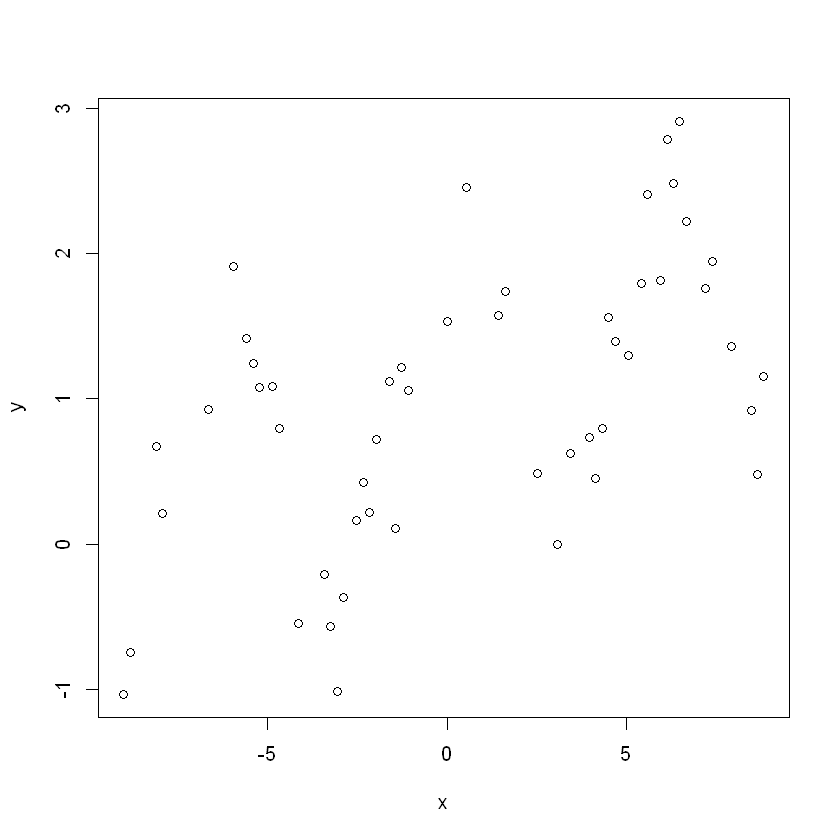

In [109]:
# WRITE YOUR CODE HERE
plot(df_train)

How would you describe the relationship between $x$ and $y$ based on this plot?

> Looks like a positive correlation at the very least. There may be a zig-zag pattern, but if we ignore the fact that we generated y I am not sure how obvious that would be.

---
## 2. Bias-variance tradeoff: polynomial regression (4 points)

Recall that in polynomial regression we increase model complexity by expanding $x$ out to the power $k$ (which we call degree).


$$Y = \hat{\beta}_0 + \sum_{j=1}^K \hat{\beta}_jX^j $$  

$$ = poly(x,k)$$

(a) Fit a 2nd degree polynomial regression model to the training data. Plot the results. 


*Hint: Use the* `help` *function to see how to use the* `stat_smooth()` *and* `poly()` *functions.*

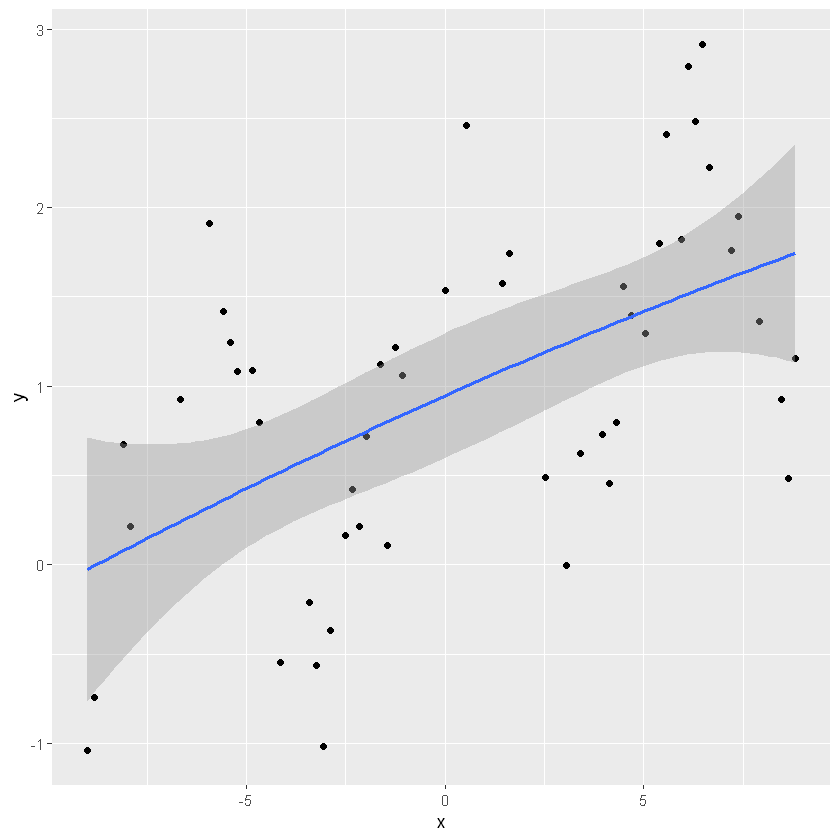

In [126]:
# WRITE YOUR CODE HERE
ggplot(df_train,aes(x,y)) +
    geom_point() +
    stat_smooth(method="glm",formula=y~poly(x,2,raw=TRUE))


How well does this 2nd degree polynomial model qualitatively fit the data? Could it do better? 

> It captures the overall trend, but otherwise does not fit very well. It could definitely do better.

(b) Fit a 12th degree polynomial to the data. Does this do qualitatively better or worse than the 2nd degree model?

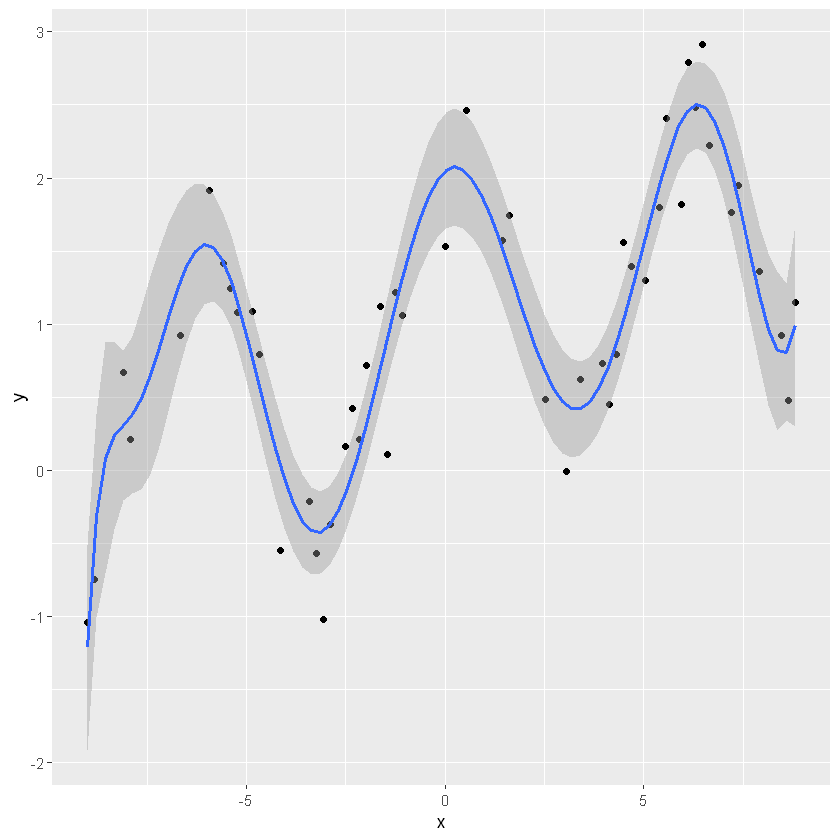

In [127]:
# WRITE YOUR CODE HERE
ggplot(df_train,aes(x,y)) +
    geom_point() +
    stat_smooth(method="glm",formula=y~poly(x,12,raw=TRUE))


> This does much better.

(c) Modify the loop below to estimate the bias-variance tradeoff as model complexity (i.e., degree of the polynomial model, $k$) increases from 2 to 50. Use the training data to fit the model and test data to evaluate its predictive accuracy. 

Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree. 


(**Note**: We are using median accuracies here because there are often 1 or 2 outlier values in the higher degree polynomial models that can throw off the accuracy estimates).

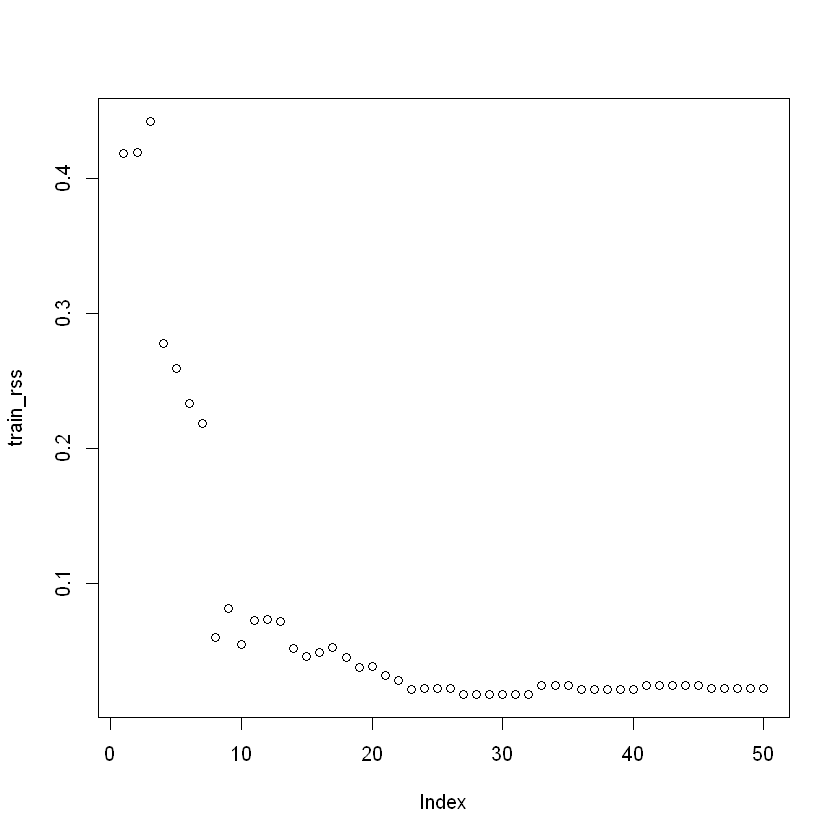

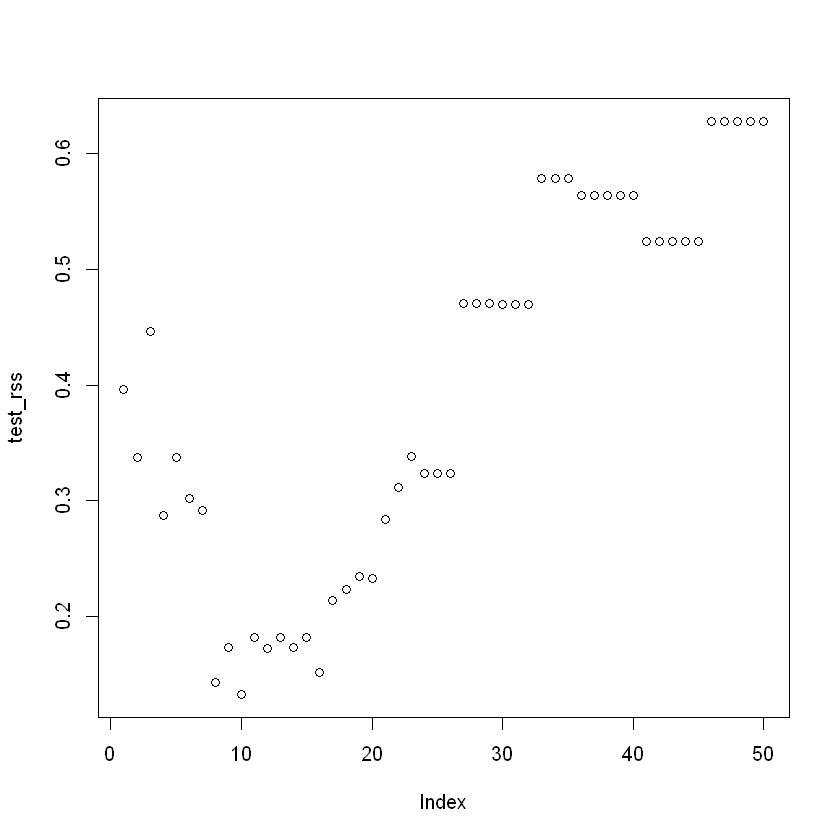

In [128]:
# Now do the variance-bias trade off analysis using regular regression
degree = 1:50

# Need to setup your output vectors
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
    lm = lm(y~poly(x,k,raw=TRUE),data=df_train)
    pred_train = predict(lm,df_train)
    pred_test = predict(lm,df_test)
    train_rss[k] = median((pred_train-df_train$y)^2)
    test_rss[k] = median((pred_test-df_test$y)^2)
}

# Plot your results here
plot(train_rss)
plot(test_rss)


What do you see as $k$ increase?

> We see that train RSS goes down as k increases. Test RSS goes down too initially, but starts going up as we begin to overfit the training set.

(d) Now copy the code above and let's see what happens when we go beyond $p=n$ (remember, in this case $k=p$). Test polynomial models up to $k=150$. Visualize your results by plotting the *median* squared error for the training data and test data as a function of polynomial degree. 

Use the `geom_vline()` function in `ggplot` to draw a vertical line where $k=n$ (here $n$ is the number of observations in the training set). This will make it clear where we cross the threshold for finding *unique* solutions in our data.



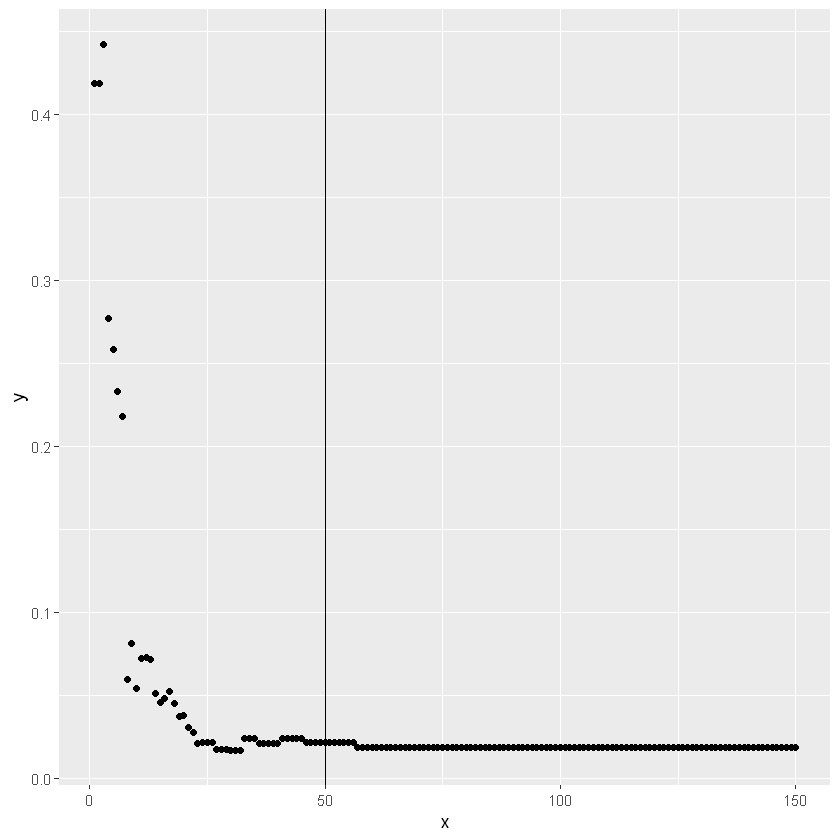

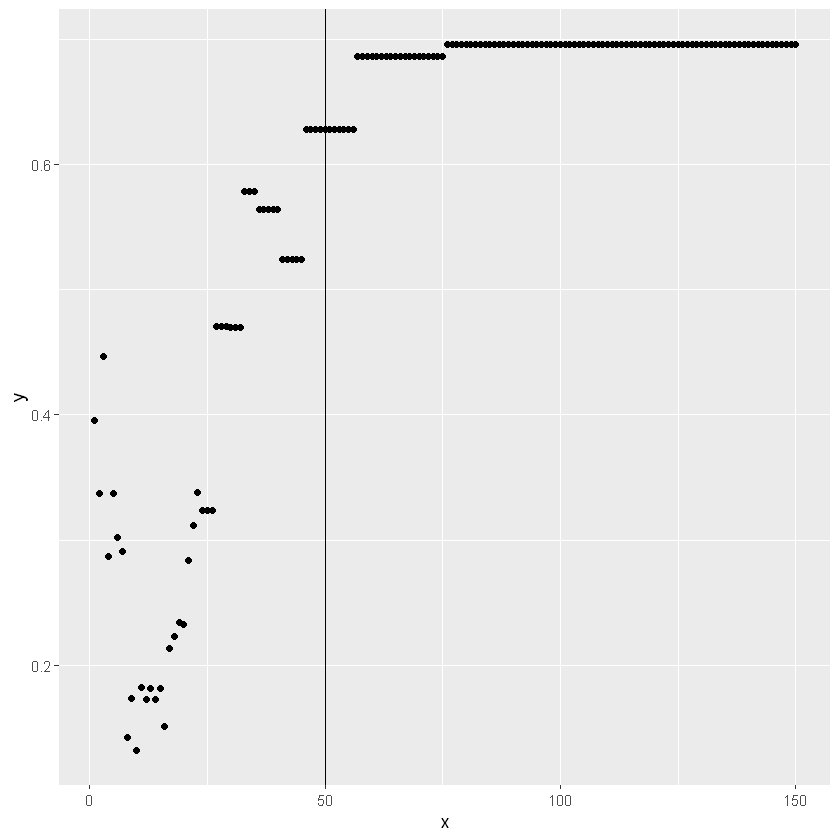

In [129]:
# WRITE YOUR CODE HERE
degree = 1:150
options(warn=-1)

# Need to setup your output vectors
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

for (k in degree) {
    lm = lm(y~poly(x,k,raw=TRUE),data=df_train)
    pred_train = predict(lm,df_train)
    pred_test = predict(lm,df_test)
    train_rss[k] = median((pred_train-df_train$y)^2)
    test_rss[k] = median((pred_test-df_test$y)^2)
}

train_rss = data.frame(cbind(1:150,train_rss))
colnames(train_rss) = c("x","y")
test_rss = data.frame(cbind(1:150,test_rss))
colnames(test_rss) = c("x","y")

# Plot your results here
ggplot(train_rss,aes(x,y)) + geom_point() + geom_vline(xintercept=50)
ggplot(test_rss,aes(x,y)) + geom_point() + geom_vline(xintercept=50)

What do you see as $k$ gets larger than $n$?

> RSS stops changing as k gets larger than n.

---
## 3. Applying regularization to the model fits (2 points)

Repeat the previous bias-variance tradeoff test, going up to $k=150$, but now use ridge regression with a sparsity parameter of $\lambda=0.00005$. Plot your results the same way as last time. 

In [159]:
# Now do the variance-bias trade off analysis using ridge regression
lambda = 0.00005
degree = seq(2,150)

rm(train_rss, test_rss)
train_rss = matrix(data=NA,nrow=length(degree),ncol=1)
test_rss = matrix(data=NA,nrow=length(degree),ncol=1)

x = cbind(x,x)
for (k in degree) {
    # WRITE YOUR CODE HERE
    x = model.matrix(y~poly(x,k,raw=TRUE),df_train)[,-1]
    y = df_train$y
    net = glmnet(x, y, alpha=0, lambda=lambda)
    pred_train = predict(net,newx=df_train[,-y])
    pred_test = predict.glmnet(net,newx=df_test$x)
    train_rss[k] = median((pred_train-df_train$y)^2)
    test_rss[k] = median((pred_test-df_test$y)^2)
}

# Plot your results here
# WRITE YOUR CODE HERE


ERROR: Error in predict.glmnet(net, newx = df_train$x): The number of variables in newx must be 2


What happens now when $k$ gets larger than $n$?

> *Write your response here* 
> 

---
## 4. Reflection (2 points)

The simulations above should have shown that, when applying a regularization (i.e., a sparsity constraint), the behavior of the bias-variance tradeoff changes. Explain why this happens.

> I wasn't able to do the above but I think it would reduce the increase in variance, thus allowing you to add more coefficients before reaching the "optimal" model.

--- 
## Bonus (1 extra credit point)
Recall that the $p=n$ threshold defines the limit for finding a *unique* solution to $Y=F(X)$ (i.e., there is only one combination of regression coefficients that is *best* at explaining variance in $Y$). With this in mind, what is regularization doing that works around this upper limit?

> It reduces the impact that "extraneous" or not major coefficients have on the model, so adding more than the unique solutions is more acceptable.

**DUE:** 5pm EST, April 12, 2023

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*